Processing an existing dataset for long-form question answering to filter out overly long answers.

In [ ]:
# Cut off value for the maximum number of tokens in the answer
MAX_TOKENS_ANSWER = 512

In [1]:
import datasets

# Long-form question answering dataset, nicely preprocessed already.
# Similar to ELI5: https://facebookresearch.github.io/ELI5/index.html (which is unavailable now)
dataset_lfqa = datasets.load_dataset("LLukas22/lfqa_preprocessed")
dataset_lfqa

DatasetDict({
    train: Dataset({
        features: ['question', 'answer', 'context'],
        num_rows: 226147
    })
    validation: Dataset({
        features: ['question', 'answer', 'context'],
        num_rows: 3020
    })
})

In [2]:
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=4):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)

    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, datasets.ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
    display(HTML(df.to_html()))

show_random_elements(dataset_lfqa["train"], num_examples=0)

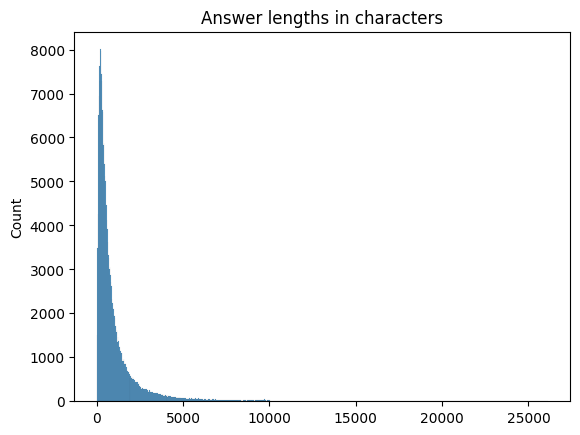

In [28]:
import seaborn as sns

answer_str_lens = [len(answer) for answer in dataset_lfqa["train"]["answer"]]
sns_plot = sns.histplot(answer_str_lens).set_title("Answer lengths in characters")
sns_plot.get_figure().savefig("plots/answer-lengths-chars-original.png")

In [4]:
# Max answer length in characters --> few answers are very long --> long-tail distribution
max(answer_str_lens)

26123

In [5]:
# Check max length (in tokens) of answers in the dataset
from transformers import AutoTokenizer
from tqdm import tqdm
import torch

tokenizer = AutoTokenizer.from_pretrained("allenai/led-base-16384")

answer_token_lens = torch.tensor(
    [
        len(tokenizer(answer)["input_ids"])
        for answer in tqdm(dataset_lfqa["train"]["answer"])
    ]
)

100%|██████████| 226147/226147 [01:47<00:00, 2106.62it/s]


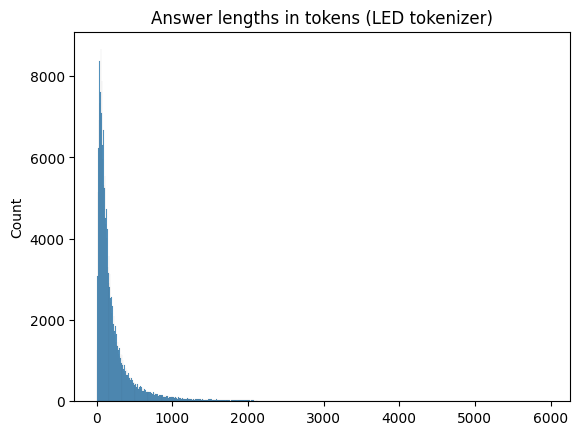

In [29]:
sns_plot = sns.histplot(answer_token_lens).set_title("Answer lengths in tokens (LED tokenizer)")
sns_plot.get_figure().savefig("plots/answer-lengths-tokens-original.png")

In [7]:
# Max answer length in tokens
answer_token_lens.max()

tensor(5964)

In [15]:
answer_token_lens.float().mean()

tensor(228.0979)

In [ ]:
# How many anwers are longer than MAX_TOKENS_ANSWER tokens?
print(sum(answer_token_lens > MAX_TOKENS_ANSWER) / len(answer_token_lens))

tensor(0.1034)


In [18]:
# Check max length (in tokens) in the validation set
answer_token_lens_val = torch.tensor(
    [
        len(tokenizer(answer)["input_ids"])
        for answer in tqdm(dataset_lfqa["validation"]["answer"])
    ]
)
answer_token_lens_val.max()

100%|██████████| 3020/3020 [00:01<00:00, 1785.72it/s]


tensor(2414)

In [19]:
print(sum(answer_token_lens_val > MAX_TOKENS_ANSWER) / len(answer_token_lens_val))

tensor(0.1238)


In [20]:
# Drop answers longer than MAX_TOKENS_ANSWER tokens
dataset_lfqa_filtered = dataset_lfqa.filter(
    lambda example: tokenizer(example["answer"], return_tensors="pt", return_length=True)["length"] <= MAX_TOKENS_ANSWER
)
dataset_lfqa_filtered

Filter:   0%|          | 0/226147 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3020 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['question', 'answer', 'context'],
        num_rows: 202767
    })
    validation: Dataset({
        features: ['question', 'answer', 'context'],
        num_rows: 2646
    })
})

In [ ]:
# Validate results
answer_token_lens_filtered = torch.tensor(
    [
        len(tokenizer(answer)["input_ids"])
        for answer in tqdm(dataset_lfqa_filtered["train"]["answer"])
    ]
)

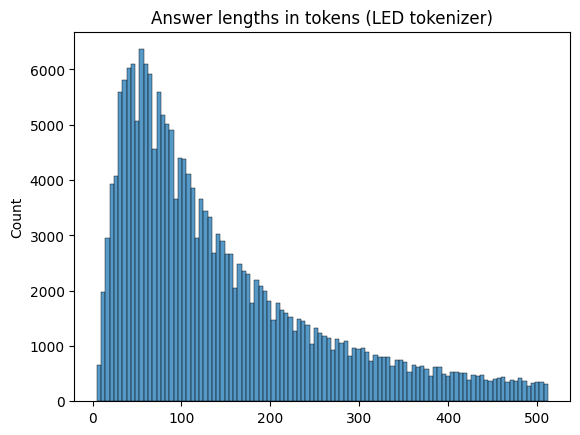

In [30]:

sns_plot = sns.histplot(answer_token_lens_filtered).set_title("Answer lengths in tokens (LED tokenizer)")
sns_plot.get_figure().savefig("plots/answer-lengths-tokens-filtered.png")

In [22]:
answer_token_lens_filtered.max()

tensor(512)

In [23]:
# Same for validation set
answer_token_lens_val_filtered = torch.tensor(
    [
        len(tokenizer(answer)["input_ids"])
        for answer in tqdm(dataset_lfqa_filtered["validation"]["answer"])
    ]
)
answer_token_lens_val_filtered.max()

100%|██████████| 2646/2646 [00:00<00:00, 2846.88it/s]


tensor(512)

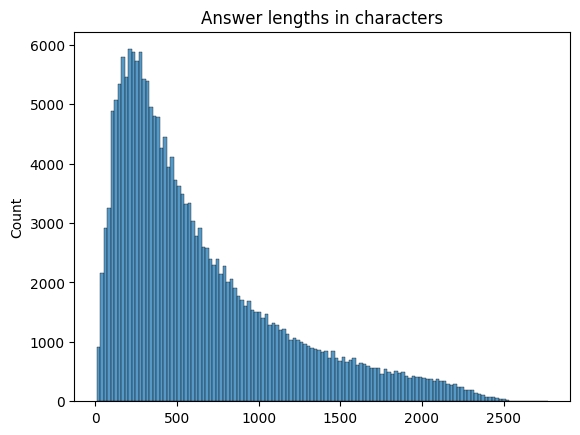

In [31]:
answer_str_lens_filtered = [len(answer) for answer in dataset_lfqa_filtered["train"]["answer"]]
sns_plot = sns.histplot(answer_str_lens_filtered).set_title("Answer lengths in characters")
sns_plot.get_figure().savefig("plots/answer-lengths-chars-filtered.png")

In [25]:
max(answer_str_lens_filtered)

2771

We cut off the way out outliers without modifying the distribution and without losing too much data.

In [26]:
dataset_lfqa_filtered.push_to_hub(f"stefanbschneider/lfqa-max-answer-length-{MAX_TOKENS_ANSWER}")

Uploading the dataset shards:   0%|          | 0/3 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/68 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/68 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/68 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/stefanbschneider/lfqa-max-answer-length-512/commit/475c4f1ae4f28023c20851a54893c6a63aed5901', commit_message='Upload dataset', commit_description='', oid='475c4f1ae4f28023c20851a54893c6a63aed5901', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/stefanbschneider/lfqa-max-answer-length-512', endpoint='https://huggingface.co', repo_type='dataset', repo_id='stefanbschneider/lfqa-max-answer-length-512'), pr_revision=None, pr_num=None)